# ДЗ 4 Датасет

Цель:
Собрать и подготовить свой собственный датасет, можно в соответствии с темой будущего проекта.
Аугментировать данные техниками из занятия.

**Описание/Пошаговая инструкция выполнения домашнего задания:**
- Взять предобученную модель.
- Применить несколько стратегий аугментации данных (albumentations, torchvision или еще что-то на ваш вкус).
- Собрать результаты успешности стратегий в сводную табличку.
- Большим плюсом будет применение Pytorch Lightning для упорядочивания вашего проекта, но это не обязательное требование.

Для решения задачи буду использовать датасет для детекции курящих vs некурящих людей. В будущем этот датасет буду еще дополнять, но для ДЗ в основу возьму данные из этой [статьи](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8839928/) , так как мне предстоит похожее исследование.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import cv2 as cv
import os
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Посмотрим рандомные картинки из датасета, для этого подготовлю функцию.

In [2]:
def view_random_images(cols, rows, path_to_images):
    fig = plt.figure(figsize = (2 * cols-1, 2.5*rows -1))
    images = os.listdir(path_to_images)
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(images))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            img = cv.imread(os.path.join(path_to_images, images[random_index]))
            ax.imshow(img[..., ::-1])
            plt.title(img.shape)
    plt.show()

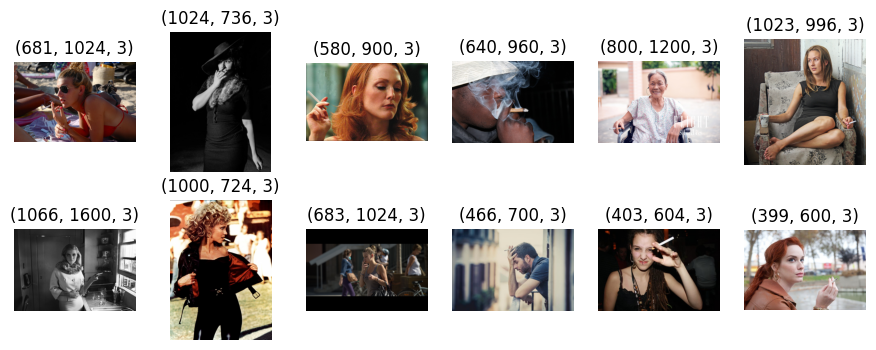

In [3]:
view_random_images(6, 2, "dataset_smoking/train/smoking")

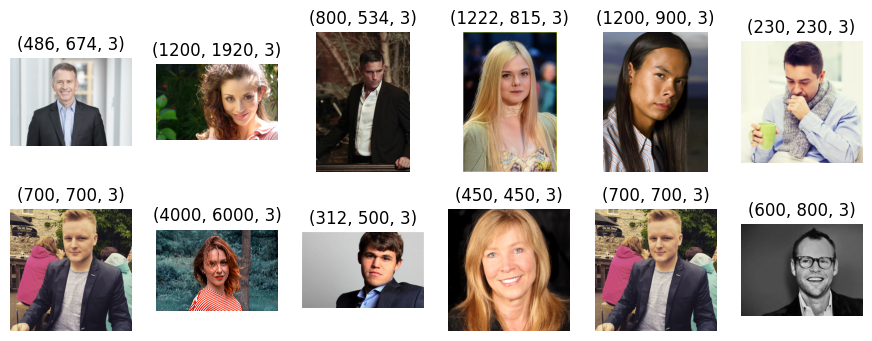

In [4]:
view_random_images(6, 2, "dataset_smoking/train/notsmoking")

Для экспериментов с дополнением и изменением датасетов сделаю две функции:

- create_datasets - для преобразования датасета без дополнения данных
- create_concat_datasets - для преобразования и дополнения исходного датасета с учетом преобразований

In [5]:
def create_datasets(path_to_data, batch_size, transforms):
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(path_to_data, x), transforms[x]
        )
        for x in ["train", "val"]
    }

    # create dataloaders
    train_dataloader = torch.utils.data.DataLoader(
        image_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True,
        persistent_workers=True,
    )
    val_dataloader = torch.utils.data.DataLoader(
        image_datasets["val"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        drop_last=True,
        persistent_workers=True,
    )

    dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
    print(dataset_sizes)
    return train_dataloader, val_dataloader

In [6]:
def create_concat_datasets(path_to_data, batch_size, transforms, transforms2, transforms3, transforms4):
    image_datasets_original = {
        x: datasets.ImageFolder(os.path.join(path_to_data, x), transforms[x])
        for x in ["train", "val"]
    }

    image_datasets_transformed1 = {
        x: datasets.ImageFolder(os.path.join(path_to_data, x), transforms2[x])
        for x in ["train", "val"]
    }
    image_datasets_transformed2 = {
        x: datasets.ImageFolder(os.path.join(path_to_data, x), transforms3[x])
        for x in ["train", "val"]
    }
    image_datasets_transformed3 = {
        x: datasets.ImageFolder(os.path.join(path_to_data, x), transforms4[x])
        for x in ["train", "val"]
    }
    increased_dataset_train = torch.utils.data.ConcatDataset(
        [
            image_datasets_original["train"],
            image_datasets_transformed1["train"],
            image_datasets_transformed2["train"],
            image_datasets_transformed3["train"],
        ]
    )

    # create dataloaders
    train_dataloader = torch.utils.data.DataLoader(
        increased_dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True,
        persistent_workers=True,
    )
    val_dataloader = torch.utils.data.DataLoader(
        image_datasets_original["val"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        drop_last=True,
        persistent_workers=True,
    )
    print(f'train:{len(increased_dataset_train)}, val: {len(image_datasets_original["val"])}')
    return train_dataloader, val_dataloader

Использовать буду предобученную модель ResNet 50, обучать буду только послдений классификационный слой. Воспользуюсь также фреймворком Pytorch Lightining для ускорения и урощения кода для fine-tune модели.

Результаты обучения буду логировать в wandb в публичный репозиторий, который можно посмотреть по [ссылке](https://wandb.ai/shakhova/wandb-lightning/workspace?nw=nwuserkatya_shakhova)



In [7]:
def get_model(num_classes):
    weights = models.ResNet50_Weights.DEFAULT
    model = models.resnet50(weights=weights)
    # Update the fully connected layer based on the number of classes in the dataset
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    for name, param in model.named_parameters():
        if "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    return model

Создам класс для модели, в нем укажу паарамтеры обучения и валидации

In [8]:
class LitModel(pl.LightningModule):
    def __init__(self, num_epochs, len_dataset, learning_rate):
        super().__init__()
        self.model = get_model(num_classes=2)
        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.len_dataset = len_dataset

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss, on_epoch = True, on_step=False, logger = True)
        self.log("train_acc", acc, on_epoch=True, on_step=False, logger = True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.learning_rate,
            epochs=self.num_epochs,
            steps_per_epoch=self.len_dataset,
        )
        return [optimizer], [scheduler]

# Вариант 1
Данный вариант не предусматривает дополнительных аугментаций кроме resize до размера, необходимого для сети. Возьму этот вариант в качестве baseline


In [9]:
data_transforms_baseline = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

experiment_name = '50baseline'

train_dl, val_dl = create_datasets("dataset_smoking", 16, data_transforms_baseline)

{'train': 1610, 'val': 400}


In [10]:
num_epochs = 50
len_dataset = len(train_dl)
learning_rate = 0.001

wandb_logger = WandbLogger(project="wandb-lightning", name  = experiment_name)
trainer = pl.Trainer(max_epochs=num_epochs, logger=wandb_logger, gradient_clip_val=0.1)
model = LitModel(num_epochs, len_dataset, learning_rate)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: katya_shakhova (shakhova). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 23.5 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:05<00:00, 17.68it/s, v_num=1zy3, val_loss=0.269, val_acc=0.913]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:05<00:00, 16.97it/s, v_num=1zy3, val_loss=0.269, val_acc=0.913]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇██████████████████
train_loss,█▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇███████▇██████
val_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_acc,0.90875
train_loss,0.25878
trainer/global_step,4999
val_acc,0.9125


Обучилась модель неплохо, хотя ниже чем у авторов статьи, максимлаьная точность классификации получилась 91,25%

# Вариант 2.
В этом варианте использую всевозможные трансформации, связанные с геометрическими изменениями (без изменения цвета, шума и т.д.). Опять же здесь не подразумевается дополнения данных.

In [11]:
data_transforms_2 = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(20),
            transforms.RandomAffine(20),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

experiment_name = "50transforms2"
train_dl, val_dl = create_datasets("dataset_smoking", 16, data_transforms_2)

{'train': 1610, 'val': 400}


In [12]:
num_epochs = 50
len_dataset = len(train_dl)
learning_rate = 0.001

wandb_logger = WandbLogger(project="wandb-lightning", name=experiment_name)
trainer = pl.Trainer(max_epochs=num_epochs, logger=wandb_logger, gradient_clip_val=0.1)
model = LitModel(num_epochs, len_dataset, learning_rate)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 23.5 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s, v_num=8evw, val_loss=0.397, val_acc=0.788]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:06<00:00, 15.63it/s, v_num=8evw, val_loss=0.397, val_acc=0.788]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇████████████
train_loss,█▇▇▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▄▅▄▅▅▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇█▇███▇████▇██▇███▇▇
val_loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁
epoch,49
train_acc,0.87875
train_loss,0.31437
trainer/global_step,4999
val_acc,0.7875


Интересно, что такая трансформация ухудшила метрики модели. Точность предсказаний упада до 78,75% на валидационном датасете. Предложенные трансофрмации слишком искажали учебные данные и модель недостаточно хорошо обобщала данные для классификации на валидацинном датасете.

# Вариант 3.
Здесь оставлю только одну трансофрмацию - рандомный горизонтальный переворот - и посмотрю, будет ли отличие от baseline

In [13]:
data_transforms_21 = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

experiment_name = "50transforms21"
train_dl, val_dl = create_datasets("dataset_smoking", 16, data_transforms_21)

{'train': 1610, 'val': 400}


In [14]:
num_epochs = 50
len_dataset = len(train_dl)
learning_rate = 0.001

wandb_logger = WandbLogger(project="wandb-lightning", name=experiment_name)
trainer = pl.Trainer(max_epochs=num_epochs, logger=wandb_logger, gradient_clip_val=0.1)
model = LitModel(num_epochs, len_dataset, learning_rate)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 23.5 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:05<00:00, 17.94it/s, v_num=hip9, val_loss=0.276, val_acc=0.905]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:05<00:00, 17.18it/s, v_num=hip9, val_loss=0.276, val_acc=0.905]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇████████████████████
train_loss,█▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▄▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇███████
val_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_acc,0.91312
train_loss,0.24643
trainer/global_step,4999
val_acc,0.905


В приниципе особых отличий нет, даже немного хуже стало, но разница незначительная. Лучший результат при такой стратегии трансформации 90,5% vs 91.25% на baseline

# Вариант 4.
Здесь уже все трансформации буду использовать как дополнения к датасету, т.е. увеличиться размер датасета: с 1610 примеров в train до 6440 примеров в train. Трансофрмации будут такими же как и в предыдущем примере, но их буду добавлять к основному датасету.

In [15]:
data_transforms_3 = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_transforms_4 = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomRotation(20),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_transforms_5 = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomAffine(20),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [16]:
train_dl, val_dl = create_concat_datasets(
    "dataset_smoking",
    16,
    data_transforms_baseline,
    data_transforms_3,
    data_transforms_4,
    data_transforms_5,
)


experiment_name = "50transf_and_augm"

train:6440, val: 400


In [17]:
num_epochs = 50
len_dataset = len(train_dl)
learning_rate = 0.001

wandb_logger = WandbLogger(project="wandb-lightning", name=experiment_name)
trainer = pl.Trainer(max_epochs=num_epochs, logger=wandb_logger, gradient_clip_val=0.1)
model = LitModel(num_epochs, len_dataset, learning_rate)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 23.5 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 402/402 [00:19<00:00, 20.29it/s, v_num=su10, val_loss=0.216, val_acc=0.905]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 402/402 [00:20<00:00, 20.01it/s, v_num=su10, val_loss=0.216, val_acc=0.905]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇█▇████████████████
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▂▃▁▂▃▄▄▆▇▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇█▆▆█▇▆▆▇▇▇▆▆▇█▆▇
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁
epoch,49
train_acc,0.919
train_loss,0.20786
trainer/global_step,20099
val_acc,0.905


В этом случае обучение было немного дольше, но особого прироста в метрике эти дополнения не принесли. Максимальная величина метрики 90,5 % vs 91.25% в baseline. Скорее всего нужно будет поменять модель, как у авторов статьи и попробовать оставить только более простые дополнения в датасете (например, только поворот).

Графики обучени из wandb на принт-скрине ниже.

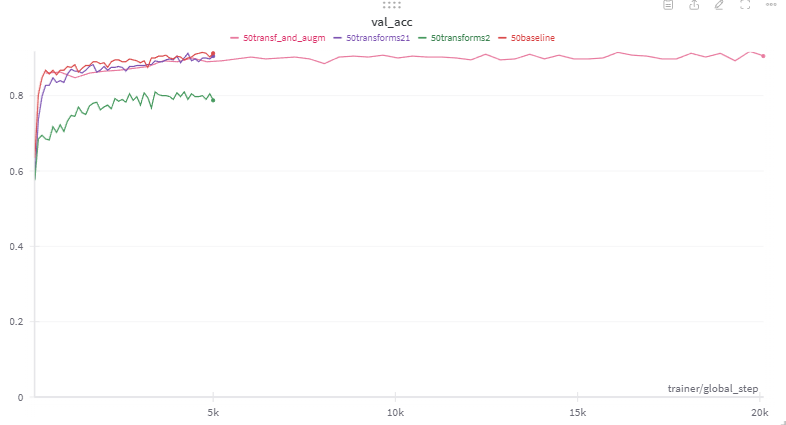